In [96]:
#Importation des librairies et fonction utiles
import geopandas as gpd, matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import box
from t4gpd.morph.STGrid import STGrid

#Importation des données utiles
arbres = gpd.read_file('data/arbres_alignement_mask.shp').to_crs(epsg=2154)
buildings = gpd.read_file('data/buildings.shp').to_crs(epsg=2154)
zone = gpd.read_file('data/zone.shp').to_crs(epsg=2154)

In [97]:
#Réduction des données à la zone d'étude 'zone'
arbres = gpd.clip(arbres, zone)
buildings = gpd.clip(buildings, zone)

In [108]:
#Création des sensors qui auxquels on va assimiler des valeur suivant la proximité aux abres
sensors = STGrid(buildings, dx=20, dy=None, indoor = False, intoPoint = True).run()

#Création de la colonne voisinnage qui est un rond autour de chaque sensor de rayon 100m
sensors['voisinage'] = sensors.geometry.apply(lambda p: p.buffer(100))

#Pour la suite on va définir les arbres comme des points
arbres['point'] = arbres.geometry.apply(lambda p: p.centroid)

#On remplace les deux géometries des gdf par les nouvelles
arbres = arbres.set_geometry('point')
sensors = sensors.set_geometry('voisinage')

#On joint les deux gdf pour compter les arbres aux voisinnages des sensors
jointure = gpd.sjoin(sensors, arbres, how='left', op='intersects')

In [112]:
#Les opérations suivantes servent à créer une liste l contenant la somme des arbres autour de chaque sensors
liste = {}

for i in range(len(jointure)):
    
    key = int(jointure['gid_left'][i:i+1])
    if (key in liste):
        liste[key]+=1
    else:
        liste[key]=1
        
l = []

for cle, i in liste.items():
    l.append(i)
    
#On crée maintenant l'indice tpf (tree proximity factor) qu'on ramene sur une echelle de 0 à 1
#Pour prendre en compte les petits groupement d'arbres rapproché on applique une fonction puissance avec p < 1
m = max(l)
p = 0.3

sensors['tpf'] = pd.Series([(k/m)**p for k in l])

<AxesSubplot:title={'center':'Tree proximity factor'}>

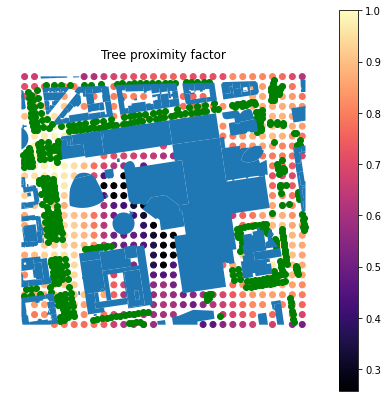

In [113]:
sensors = sensors.set_geometry('geometry')

_,basemap = plt.subplots(figsize =(7, 7))
plt.axis('off')
plt.title('Tree proximity factor')
sensors.plot(ax=basemap, cmap ='magma', column='tpf', legend=True)
arbres.plot(ax=basemap, color = 'green', legend=True)
buildings.plot(ax=basemap, legend=True)